# S1 study

- Count and classify S1s

## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-04 11:22:51


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [412]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.core.core_functions import weighted_mean_and_var
from   invisible_cities.core.core_functions import timefunc
from   invisible_cities.core.exceptions     import SipmZeroCharge
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import NN
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [6]:
from typing      import NamedTuple

## NB functions

### Utilities

In [14]:
def sort_s12s(s12s):
    return sorted(s12s, key= lambda s12 : s12.total_energy, reverse=True)

In [15]:
def kr_dst(s1s, s2s, xs, ys):
    s1 = sort_s12s(s1s)[0]
    s2 = sort_s12s(s2s)[0]
    c = compute_xy_peak_position(s2.sipms, xs, ys)
    
    return KrDst(es1 = s1.total_energy, ws1=s1.width, 
                 es2 =s2.total_energy,  ws2=s1.width, qs2=s2.total_charge, 
                 dt = (s2.time_at_max_energy - s1.time_at_max_energy) / units.mus,
                 c = c)
    

In [193]:
def file_list(run_number, file_numbers, path='/Users/jjgomezcadenas/Projects/ICDEV/data'):
    return ['{}/run_{}_{}_waveforms.h5'.format(path, run_number, file_number) for file_number in file_numbers]

In [190]:
def create_empty_lists(number_of_lists = 2):
    return ([] for i in range(number_of_lists))
    

### Types

In [16]:
class Cluster(NamedTuple):
    Q     : float
    x     : float 
    y     : float
    nsipm : int

In [374]:
class DummyS2(NamedTuple):
    total_energy       : float
    width              : float 
    time_at_max_energy : float
    

### Analysis

In [18]:
def compute_xy_peak_position(sr, xs, ys):
        """
        Computes position using the integral of the charge
        in each SiPM. Config parameters set equal to the standard kDST values.
        """
        IDs = sr.ids
        Qs = sr.sum_over_times
        xs, ys   = xs[IDs], ys[IDs]
        cls      = corona(np.stack((xs, ys), axis=1), Qs,
                      Qthr           =  1.,
                      Qlm            =  0.,
                      lm_radius      =  -1.,
                      new_lm_radius  =  -1.,
                      msipm          =  1)
        c = cls[0]
        return Cluster(Q=c.Q, x=c._xy.x, y=c._xy.y, nsipm=c.nsipm)


In [447]:
@timefunc
def s12df(run_number, filenames, mode='S1', event_range=NN, print_every=10):
    
    s12 = False   #S1 by default 
    
    # Data base 
    DataPMT = load_db.DataPMT(run_number)
    DataSiPM = load_db.DataSiPM(run_number)
    xs = DataSiPM.X.values
    ys = DataSiPM.Y.values
    pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
    channel_id = DataPMT.ChannelID.values
    coeff_blr = abs(DataPMT.coeff_blr.values)
    coeff_c = abs(DataPMT.coeff_c .values)
    adc_to_pes = abs(DataPMT.adc_to_pes.values)
    sipm_adc_to_pes = DataSiPM.adc_to_pes.values
    
    sipm_adc_to_pes[181] = 0
    adc_to_pes[9] = 25
    
    #  S1 & S2 params 
    s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                       max    = 620 * units.mus),
                            stride = 4,
                            length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                            rebin_stride  = 1)
    
    s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                       max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
    #  Tresholds 
    s1th=  0.5 * units.pes
    s2th=  1.0 * units.pes
    sith = 10 * units.pes
    
    # DF init
    (evt, 
     ns1, cs1, es1, hs1, ws1, ts1, 
     ns2, es2, ws2, ts2,
     qs2, xs2, ys2, nsi          ) = create_empty_lists(number_of_lists = 15)
    
    # Loop
    
           
    event_number = 0
    with_event_range = False
    if isinstance(event_range, minmax): with_event_range = True
                
    for filename in filenames:
        with tb.open_file(filename, 'r') as file:
            pmtrwf = file.root.RD.pmtrwf
            sipmrwf = file.root.RD.sipmrwf
            NEVT = pmtrwf.shape[0]
            
            for event in range(NEVT):
                if with_event_range:
                    if event_number < event_range.min:
                        event_number += 1
                        continue 
                    elif event_number > event_range.max:
                        break
                
                CWF            = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, n_baseline  = 48000)
                _, _, cfsum, _ = csf.calibrate_pmts(CWF, adc_to_pes)
                
                sipm_cal       = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=sith,
                                                     bls_mode=csf.BlsMode.mode)
                
                if event_number%print_every == 0:
                    print("processing event = {}".format(event_number))
            
                s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cfsum, s1th)
                
                if s1_indx.shape[0] == 0: continue
                    
                s1s = pkf.find_peaks(cfsum, 
                                     s1_indx, 
                                     s1params.time, 
                                     s1params.length, 
                                     s1params.stride, 
                                     s1params.rebin_stride,
                                     Pk=S1, 
                                     pmt_ids=[-1], 
                                     sipm_wfs=None, 
                                     thr_sipm_s2=0)
                
                s2s = []
                s2  = DummyS2(total_energy = NN, 
                              width        = NN,
                              time_at_max_energy = NN)
                
                c = Cluster(Q     = NN,
                            x     = NN,
                            y     = NN,
                            nsipm = NN)
                
                if mode == 'S12':
                    s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cfsum, s2th)
                    if s2_indx.shape[0] > 0:
                        s12 = True
                        s2s = pkf.find_peaks(cfsum, 
                                             s2_indx, 
                                             s2params.time, 
                                             s2params.length, 
                                             s2params.stride, 
                                             s2params.rebin_stride,
                                             Pk=S2, pmt_ids=[-1], 
                                             sipm_wfs=sipm_cal, thr_sipm_s2=0)
                        if len(s2s) > 0 :
                            s2 = s2s[0]
                            try:
                                c = compute_xy_peak_position(s2.sipms, xs, ys)
                            except SipmZeroCharge:
                                c = Cluster(Q     = NN,
                                            x     = NN,
                                            y     = NN,
                                            nsipm = NN)
    
                ns1.append(len(s1s))
                ns2.append(len(s2s))
                
                if s12:
                    if len(s1s) == 0 or len(s2s) == 0 : continue
                
                
                for s1 in s1s:
                    evt.append(event_number)
                    cs1.append(len(s1s))
                    es1.append(s1.total_energy)
                    hs1.append(s1.height)
                    ws1.append(s1.width)
                    ts1.append(s1.time_at_max_energy/units.mus)
                    es2.append(s2.total_energy)
                    ws2.append(s2.width)
                    ts2.append(s2.time_at_max_energy/units.mus)
                    qs2.append(c.Q)
                    xs2.append(c.x)
                    ys2.append(c.y)
                    nsi.append(c.nsipm)
                    
                event_number +=1
                    
                    
    pdf = pd.DataFrame(np.array([evt, cs1, es1, hs1, ws1, ts1,
                                           es2,      ws2, ts2,
                                           qs2, xs2, ys2, nsi]).T,
                        columns=['evt', 'ns1', 'es1', 'hs1', 'ws1', 'ts1', 
                                               'es2',        'ws2', 'ts2',
                                               'qs2', 'xs2', 'ys2', 'nsi'])
    
    return np.array(ns1), np.array(ns2), pdf
                        

### Histograms

In [316]:
def plot_s1histos(s1df, figsize=(12,12)):
    
    fig = plt.figure(figsize=figsize) # Creates a new figure
    
    ax = fig.add_subplot(2, 2, 1)
    mu, var = weighted_mean_and_var(s1df.es1.values, np.ones(len(s1df)))
    ax.set_xlabel('S1 energy (pes)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)#ylabel
    ax.hist(s1df.es1, range=(0,30), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True)
    
    ax = fig.add_subplot(2, 2, 2) 
    mu, var = weighted_mean_and_var(s1df.ws1, np.ones(len(s1df)))
    ax.set_xlabel(r'S1 width ($\mu$s)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(s1df.ws1, range=(0,500), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True)
    
    ax = fig.add_subplot(2, 2, 3)
    mu, var = weighted_mean_and_var(s1df.hs1, np.ones(len(s1df)))
    ax.set_xlabel(r'S1 height (pes)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(s1df.hs1, range=(0,10), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True)
    
    ax = fig.add_subplot(2, 2, 4) 
    mu, var = weighted_mean_and_var(s1df.ts1, np.ones(len(s1df)))
    ax.set_xlabel(r'S1 time ($\mu$s)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(s1df.ts1, range=(0,600), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    #ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True) 



In [500]:
def plot_s2histos(df, figsize=(12,12)):
    
    fig = plt.figure(figsize=figsize) # Creates a new figure
    
    ax = fig.add_subplot(3, 2, 1)
    mu, var = weighted_mean_and_var(df.es2.values, np.ones(len(df)))
    ax.set_xlabel('S2 energy (pes)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)#ylabel
    ax.hist(df.es2, range=(0,15000), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True)
    
    ax = fig.add_subplot(3, 2, 2) 
    mu, var = weighted_mean_and_var(df.ws2/units.mus, np.ones(len(df)))
    ax.set_xlabel(r'S2 width ($\mu$s)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(df.ws2/units.mus, range=(0,50), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True)
    
    ax = fig.add_subplot(3, 2, 3)
    mu, var = weighted_mean_and_var(df.q, np.ones(len(df)))
    ax.set_xlabel(r'Q (pes)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(df.q, range=(0,1500), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True)
    
    ax = fig.add_subplot(3, 2, 4) 
    mu, var = weighted_mean_and_var(df.nsi, np.ones(len(df)))
    ax.set_xlabel(r'number SiPM',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(df.nsi, range=(0,30), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True) 
    
    ax = fig.add_subplot(3, 2, 5) 
    mu, var = weighted_mean_and_var(df.xs, np.ones(len(df)))
    ax.set_xlabel(r' X (mm)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(df.xs, range=(-200,200), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True) 
    
    ax = fig.add_subplot(3, 2, 6) 
    mu, var = weighted_mean_and_var(df.ys, np.ones(len(df)))
    ax.set_xlabel(r' Y (mm)',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)
    ax.hist(df.ys, range=(-200,200), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True) 



In [317]:
def histo_ns1(ns1, figsize=(6,6)):
    
    fig = plt.figure(figsize=figsize) # Creates a new figure
    
    ax = fig.add_subplot(1, 1, 1)
    mu, var = weighted_mean_and_var(ns1, np.ones(len(ns1)))
    ax.set_xlabel('n S1',fontsize = 11) #xlabel
    ax.set_ylabel('Frequency', fontsize = 11)#ylabel
    hns1, bins, _ = ax.hist(ns1, bins = 20, range=(0,20), 
            histtype='step',
            edgecolor='black',
            linewidth=1.5, 
            label=r'$\mu={:7.2f},\ \sigma={:7.2f}$'.format(mu, np.sqrt(var)))
    ax.legend(fontsize= 10, loc='upper right')
    plt.grid(True)
    return hns1, bins

In [168]:
def bin_ratio(histogram, bins, xbin):
    return histogram[loc_elem_1d(bins, xbin)] / np.sum(histogram)


## Goal of the study

- Compare s1 (and eventually s2) data for Krypton at different rates (effect of grass?) and with chamber in different condictions

## Data Sets

#### Run numbers:
- 5254 C =  0 kV, G =  0 kV, Kr = 15 Hz, autotrigger
- 5253 C =  7 kV, G = 30 kV, Kr = 15 Hz, autotrigger
- 5259 C = 7.5 kV, G = 30 kV, Kr = Varies, S2 trigger
    - t0 : files: 0000 - 0009 : Rate ~15 kHz (limited by DaQ, real rate in chamber higher)
    - t1 : files: 1600 - 1609 : Rate ~10 kHz
    - t2 :        2100 - 2109 :        5 kHz
    - t3 :        2210 - 2219 :        3 kHz
    - t4 :        2310 - 2319 :        < 3 kHz
    - t5 :        2420 - 2429 :        < 1 kHz

### Run 5254: chamber off

In [448]:
file_numbers = ['000{:d}'.format(i) for i in range(0,6)]
file_numbers

['0000', '0001', '0002', '0003', '0004', '0005']

In [449]:
filenames = file_list(run_number=5254, file_numbers=file_numbers)
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5254_0000_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5254_0001_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5254_0002_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5254_0003_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5254_0004_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5254_0005_waveforms.h5']

In [450]:
ns1_5254, ns2_5254, df5254 = s12df(run_number=5254, filenames=filenames, 
                                   mode='S1', event_range= minmax(0,2000), print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
processing event = 700
processing event = 800
processing event = 900
Time spent in s12df: 238.0073218345642 s


#### ns1

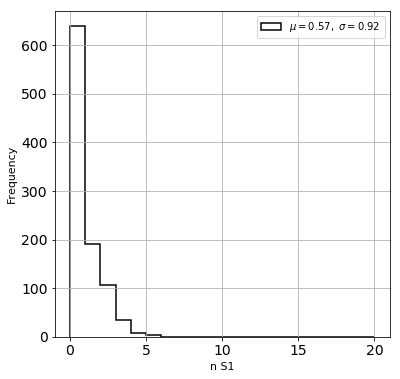

In [451]:
hns1, bins  = histo_ns1(ns1_5254)

In [452]:
bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])

#### Fraction of ns1 = 0, ns1 = 1

In [453]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.6500508646998983 1S1/tot = 0.1943031536113937 2S1/tot = 0.10783316378433368


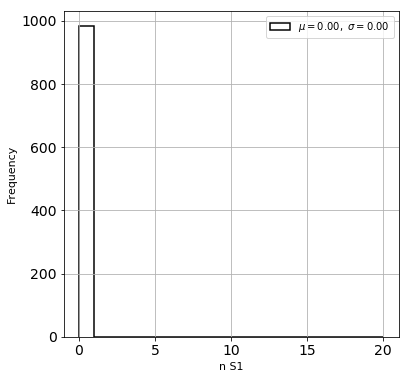

In [454]:
hns2, bins  = histo_ns1(ns2_5254)

#### Inclusive distributions

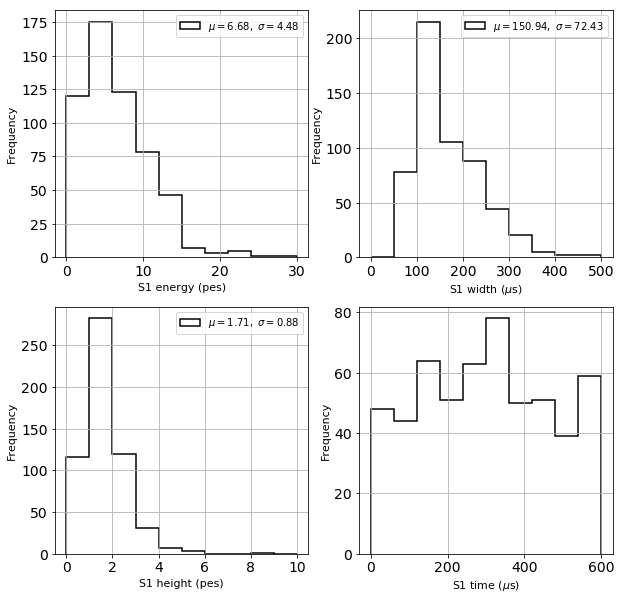

In [455]:
plot_s1histos(df5254, figsize=(10,10))

#### Distributions for ns1 = 1 and ns1=2

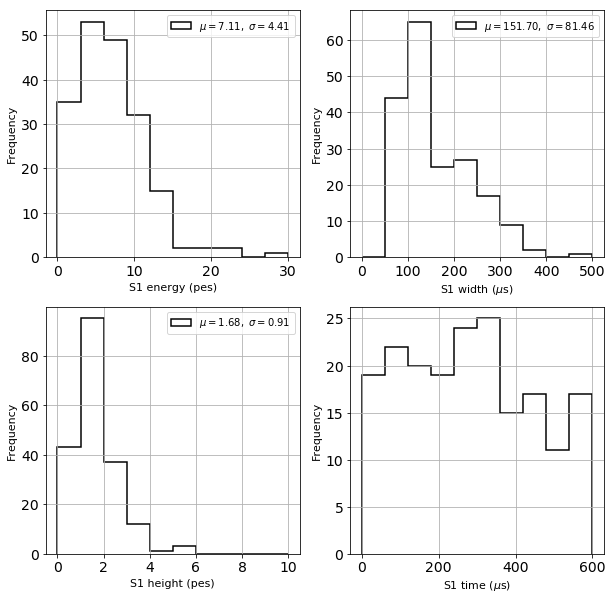

In [456]:
plot_s1histos(df5254[df5254.ns1==1], figsize=(10,10))

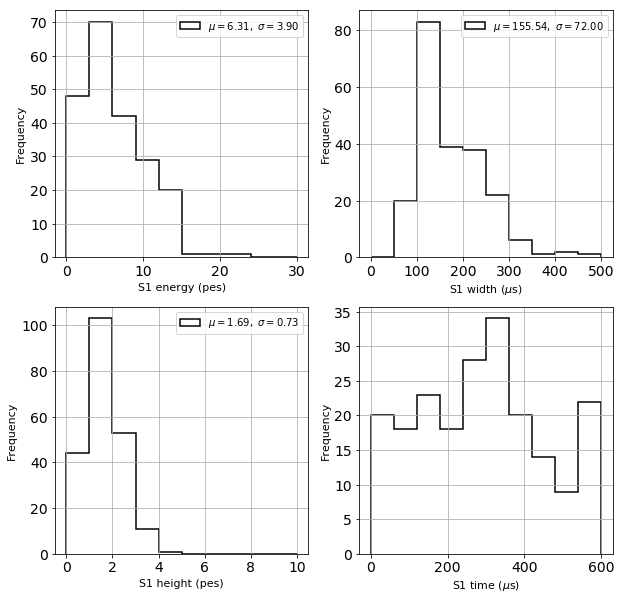

In [457]:
plot_s1histos(df5254[df5254.ns1==2], figsize=(10,10))

## Run 5253: Kr on (high), Chamber on, autotrigger

In [458]:
filenames = file_list(run_number=5253, file_numbers=file_numbers)
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5253_0000_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5253_0001_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5253_0002_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5253_0003_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5253_0004_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5253_0005_waveforms.h5']

In [459]:
ns1_5253, ns2_5253, df5253 = s12df(run_number=5253, filenames=filenames, 
                                   mode='S1', event_range= minmax(0,2000), print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
processing event = 700
processing event = 800
processing event = 900
Time spent in s12df: 238.59472012519836 s


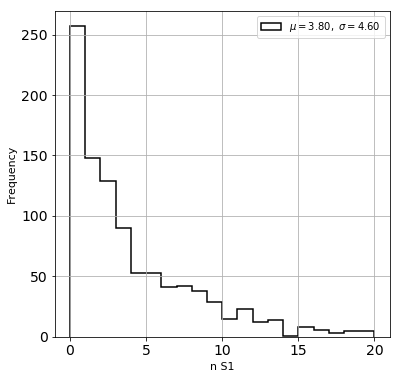

In [460]:
hns1, bins  = histo_ns1(ns1_5253)

In [461]:
bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])

In [462]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.26440329218106995 1S1/tot = 0.1522633744855967 2S1/tot = 0.13271604938271606


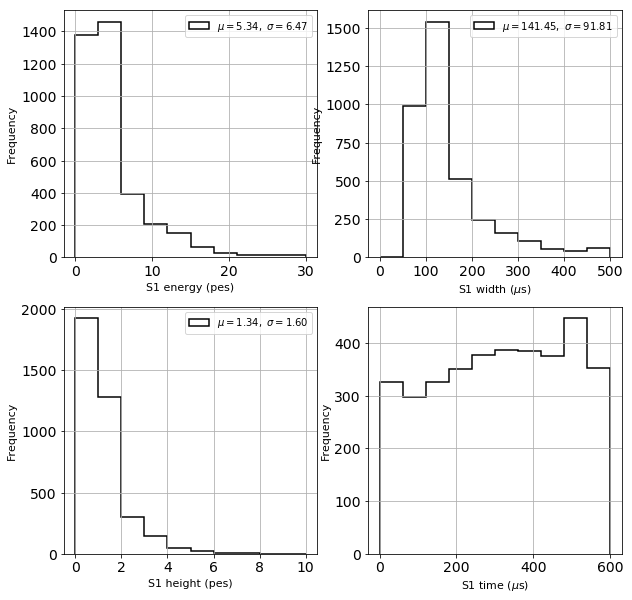

In [463]:
plot_s1histos(df5253, figsize=(10,10))

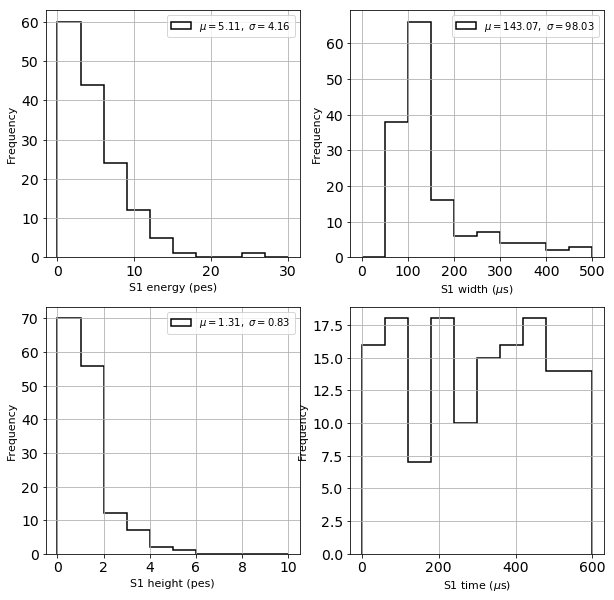

In [464]:
plot_s1histos(df5253[df5253.ns1==1], figsize=(10,10))

## Run 5259

### C = 30 kV,  G= 7.5  kV:  files 0000-0004: rate about 15 Hz

In [465]:
file_numbers = ['000{:d}'.format(i) for i in range(0,4)]
file_numbers

['0000', '0001', '0002', '0003']

In [466]:
filenames = file_list(run_number=5259, file_numbers=file_numbers)
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_0000_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_0001_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_0002_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_0003_waveforms.h5']

In [467]:
ns1_5259_t0, ns2_5259_t0, df5259_t0 = s12df(run_number=5259, filenames=filenames, 
                                            mode='S12', event_range= minmax(0,2000), print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
Time spent in s12df: 161.49468207359314 s


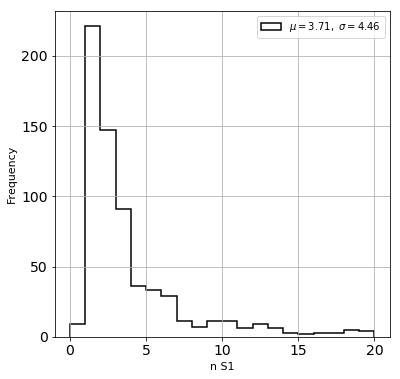

In [468]:
hns1, bins  = histo_ns1(ns1_5259_t0)

In [469]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.013910355486862442 1S1/tot = 0.3415765069551777 2S1/tot = 0.22720247295208656


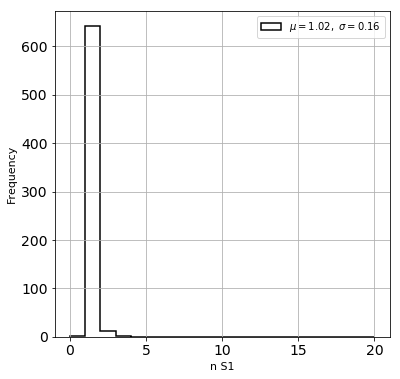

In [470]:
hns2, bins  = histo_ns1(ns2_5259_t0)

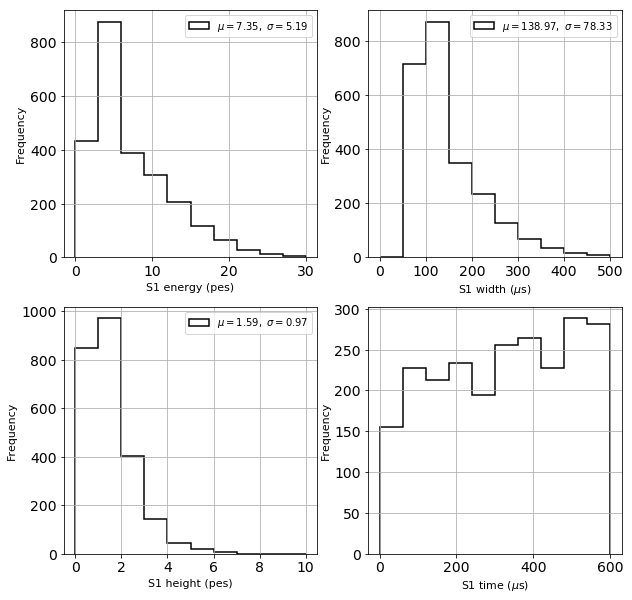

In [471]:
plot_s1histos(df5259_t0, figsize=(10,10))

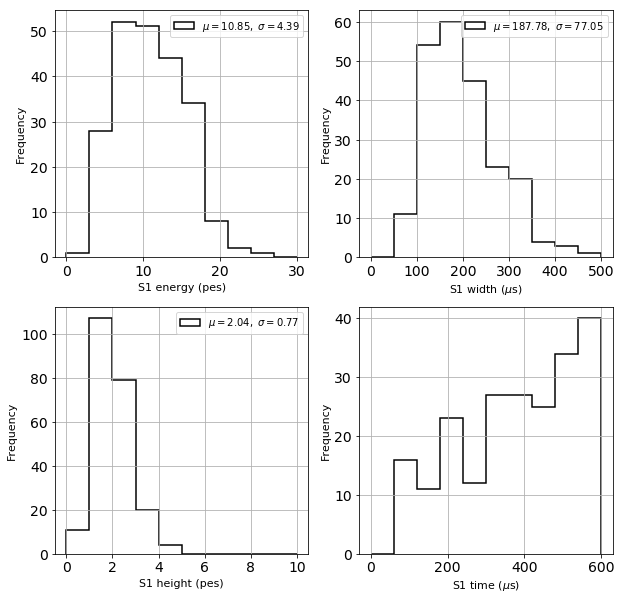

In [472]:
plot_s1histos(df5259_t0[df5259_t0.ns1==1], figsize=(10,10))

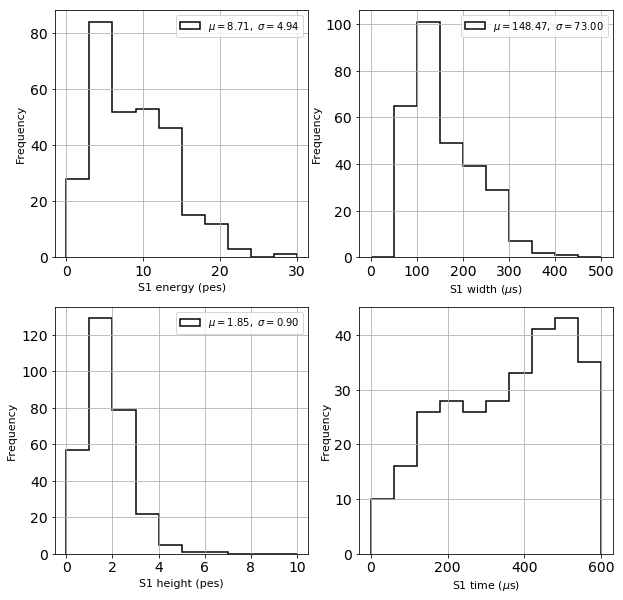

In [474]:
plot_s1histos(df5259_t0[df5259_t0.ns1==2], figsize=(10,10))

In [473]:
df = df5259_t0[df5259_t0.ns1==1]

## C = 30 kV,  G= 7.5  kV:  files 1600-1609: rate about 10 Hz

In [476]:
filenames = file_list(run_number=5259, file_numbers=range(1600,1610))
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1600_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1601_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1602_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1603_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1604_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1605_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1606_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1607_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1608_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_1609_waveforms.h5']

In [477]:
ns1_5259_t1, ns2_5259_t1, df5259_t1 = s12df(run_number=5259, filenames=filenames, 
                                            mode='S12', event_range= minmax(0,2000), print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
processing event = 700
processing event = 800
processing event = 900
processing event = 1000
processing event = 1100
processing event = 1200
processing event = 1300
processing event = 1400
processing event = 1500
Time spent in s12df: 388.9409108161926 s


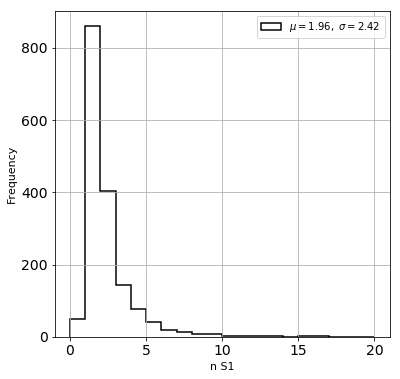

In [478]:
hns1, bins  = histo_ns1(ns1_5259_t1)

In [479]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.030525030525030524 1S1/tot = 0.525030525030525 2S1/tot = 0.24664224664224665


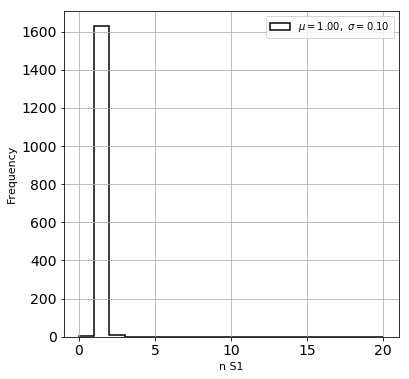

In [480]:
hns2, bins  = histo_ns1(ns2_5259_t1)

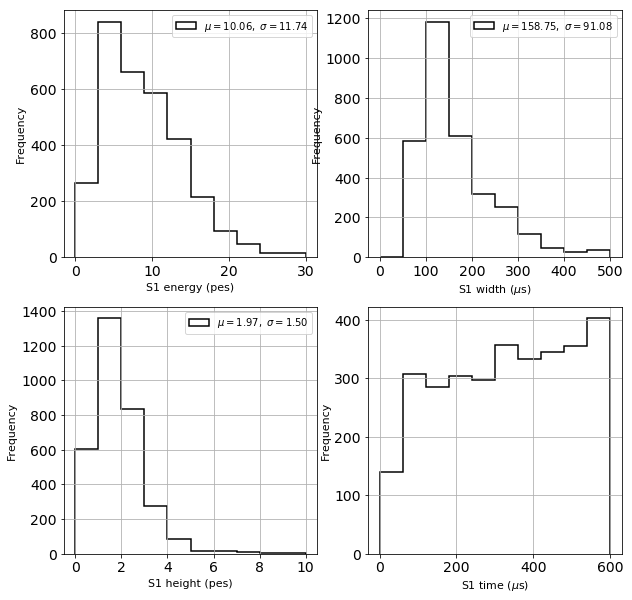

In [481]:
plot_s1histos(df5259_t1, figsize=(10,10))

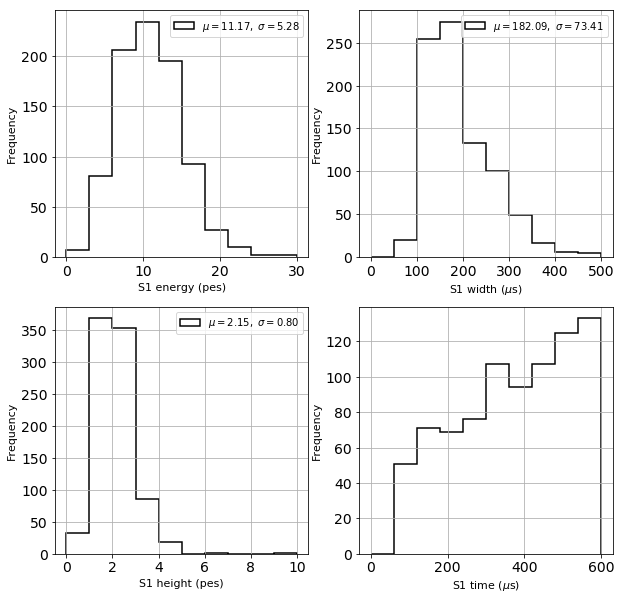

In [482]:
plot_s1histos(df5259_t1[df5259_t1.ns1==1], figsize=(10,10))

#### The rate of 1 S1 is 52 %, which is quite acceptable, the distributions with S1 = 1 are clearly consistent with Krypton events. 

## C = 30 kV,  G= 7.5  kV:  files 2100-2110: rate about 5 Hz

In [483]:
filenames = file_list(run_number=5259, file_numbers=range(2100,2110))
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2100_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2101_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2102_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2103_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2104_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2105_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2106_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2107_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2108_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2109_waveforms.h5']

In [484]:
ns1_5259_t2, ns2_5259_t2, df5259_t2 = s12df(run_number=5259, filenames=filenames, mode='S12', print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
processing event = 700
processing event = 800
processing event = 900
processing event = 1000
processing event = 1100
processing event = 1200
processing event = 1300
processing event = 1400
processing event = 1500
processing event = 1600
Time spent in s12df: 399.66608476638794 s


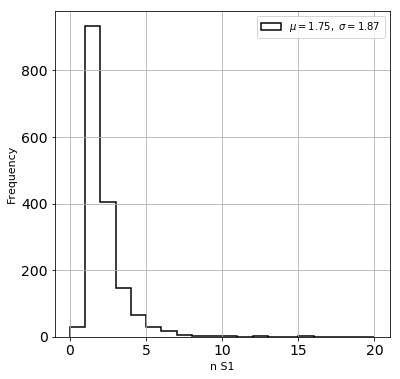

In [489]:
hns1, bins  = histo_ns1(ns1_5259_t2)

In [490]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.017083587553386213 1S1/tot = 0.5692495424039048 2S1/tot = 0.24771201952410007


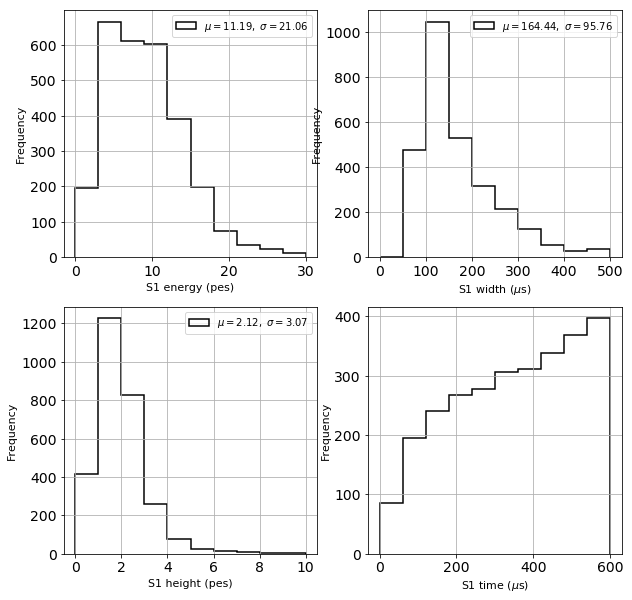

In [491]:
plot_s1histos(df5259_t2, figsize=(10,10))

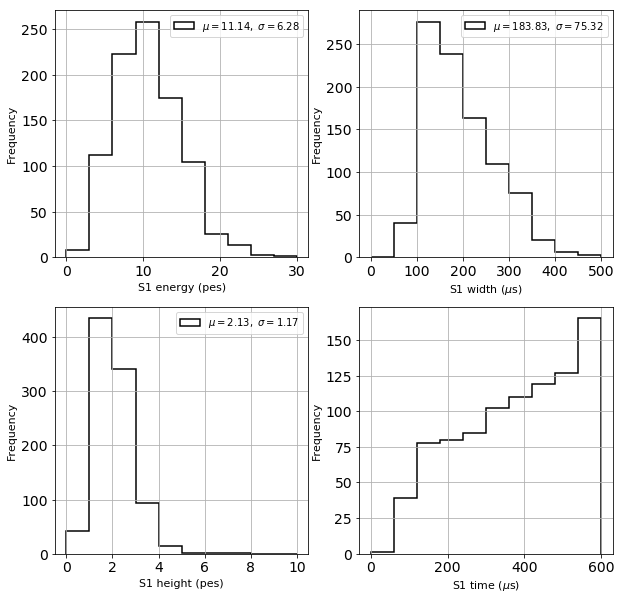

In [492]:
plot_s1histos(df5259_t2[df5259_t2.ns1==1], figsize=(10,10))

#### The rate of 1S1  increases a bit wrt 10 Hz, indicating that the best spot to run is between 5 and 10 Hz.


## C = 30 kV,  G= 7.5  kV:  files 2210-2219: rate about 3 Hz

In [487]:
filenames = file_list(run_number=5259, file_numbers=range(2210,2217))
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2210_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2211_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2212_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2213_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2214_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2215_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2216_waveforms.h5']

In [488]:
ns1_5259_t3, ns2_5259_t3, df5259_t3 = s12df(run_number=5259, filenames=filenames, mode='S12', print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
processing event = 700
processing event = 800
processing event = 900
processing event = 1000
processing event = 1100
Time spent in s12df: 278.253839969635 s


In [326]:
ns1_5259_5hz, df5259 = s1df(filenames, s1params, s1th=0.5 * units.pes )

Time spent in s1df: 125.78340888023376 s


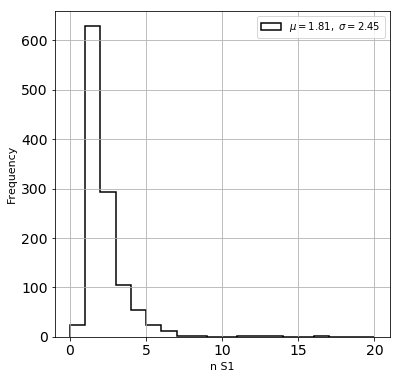

In [493]:
hns1, bins  = histo_ns1(ns1_5259_t3)

In [494]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.02005231037489102 1S1/tot = 0.5483870967741935 2S1/tot = 0.2563208369659983


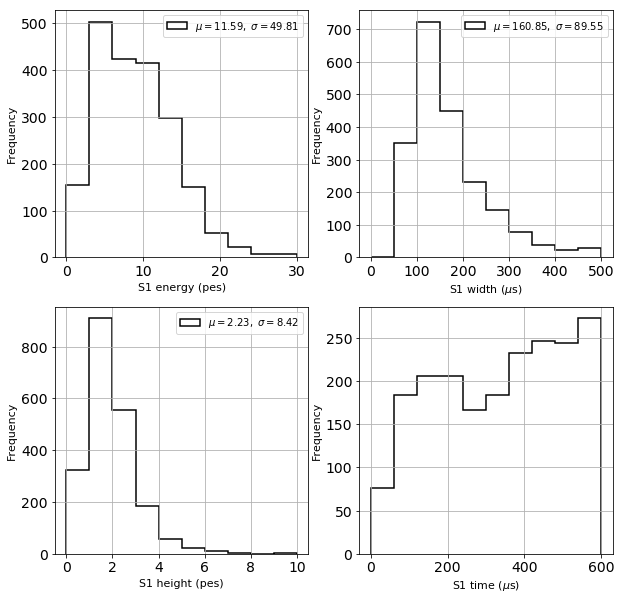

In [495]:
plot_s1histos(df5259_t3, figsize=(10,10))

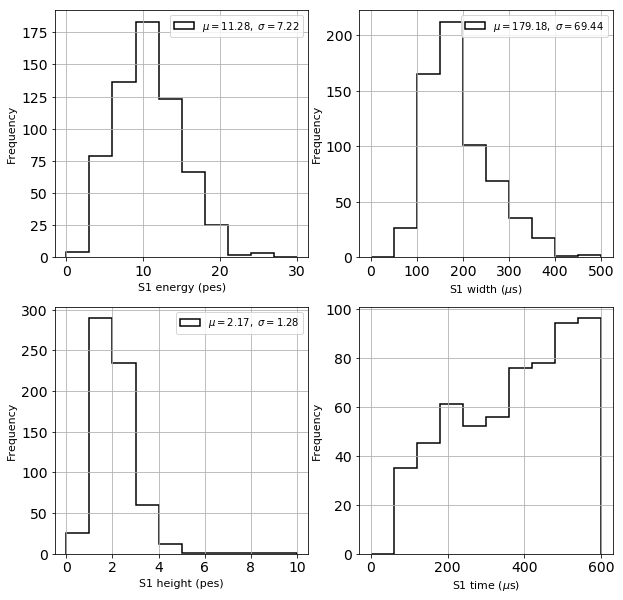

In [496]:
plot_s1histos(df5259_t3[df5259_t3.ns1==1], figsize=(10,10))

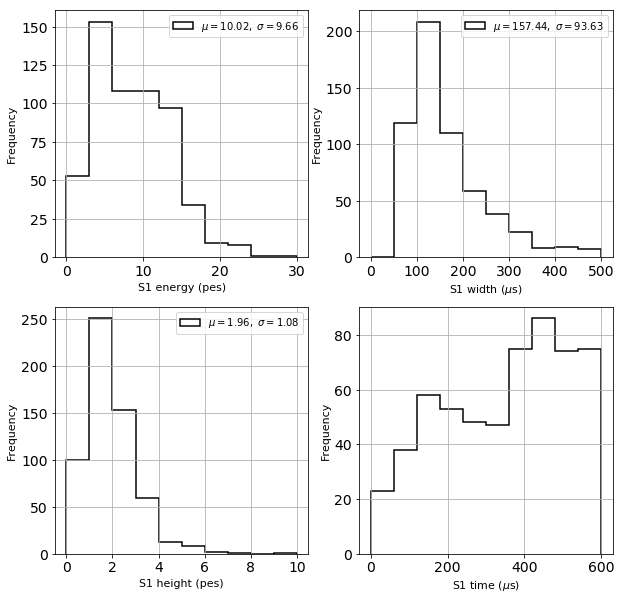

In [497]:
plot_s1histos(df5259_t3[df5259_t3.ns1==2], figsize=(10,10))

#### The rate of S1 decreases slighlty indicating that the level of grass is now stable. 

## C = 30 kV,  G= 7.5  kV:  files 2420-2429: rate < 1 Hz

In [498]:
filenames = file_list(run_number=5259, file_numbers=range(2420,2430))
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2420_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2421_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2422_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2423_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2424_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2425_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2426_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2427_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2428_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5259_2429_waveforms.h5']

In [499]:
ns1_5259_t5, ns2_5259_t5, df5259_t5 = s12df(run_number=5259, filenames=filenames, mode='S12', print_every=100)

processing event = 0
processing event = 100
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
processing event = 700
processing event = 700
processing event = 800
processing event = 900
processing event = 1000
processing event = 1100
processing event = 1200
processing event = 1300
processing event = 1400
processing event = 1500
Time spent in s12df: 399.6549320220947 s


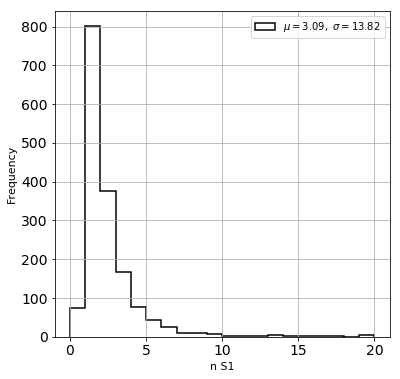

In [501]:
hns1, bins  = histo_ns1(ns1_5259_t5)

In [502]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.04641089108910891 1S1/tot = 0.49566831683168316 2S1/tot = 0.2332920792079208


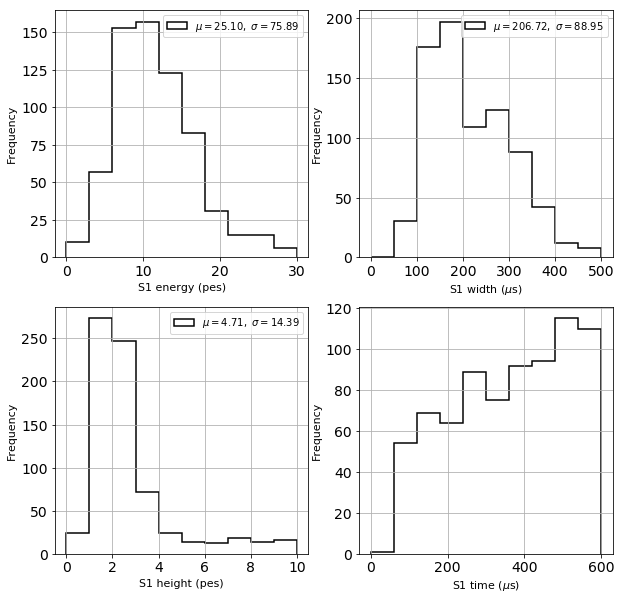

In [504]:
plot_s1histos(df5259_t5[df5259_t5.ns1==1], figsize=(10,10))

#### In this run, with Krypton almost gone, background events start to be visible, biasing the distributions towards larger S1 energy, larger width and so on. The fraction of 1 S1 events decreases slightly wrt the case of moderate Krypton.

## Run 5261 and 5262 : C = 7.7 kV

- 5261 -- 12 kHz : 1070 - 1078
- 5262 --  5 kHz : 0340 - 0349

In [505]:
filenames = file_list(run_number=5262, file_numbers=range(1070,1079))
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1070_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1071_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1072_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1073_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1074_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1075_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1076_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1077_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_1078_waveforms.h5']

In [506]:
ns1_5261, ns2_5261, df5261 = s12df(run_number=5261, filenames=filenames, mode='S12', print_every=100)

ValueError: operands could not be broadcast together with shapes (1536,1300) (1792,1) (1536,1300) (1792,1) 

In [507]:
file_numbers = ['0{:d}'.format(i) for i in range(340,350)]
file_numbers

['0340',
 '0341',
 '0342',
 '0343',
 '0344',
 '0345',
 '0346',
 '0347',
 '0348',
 '0349']

In [508]:
filenames = file_list(run_number=5262, file_numbers=file_numbers)
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0340_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0341_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0342_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0343_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0344_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0345_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0346_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0347_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0348_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0349_waveforms.h5']

In [509]:
ns1_5262, ns2_5262, df5262 = s12df(run_number=5262, filenames=filenames, mode='S12', print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
processing event = 700
processing event = 800
processing event = 900
processing event = 1000
processing event = 1100
processing event = 1200
processing event = 1300
processing event = 1400
processing event = 1500
processing event = 1600
Time spent in s12df: 399.7242441177368 s


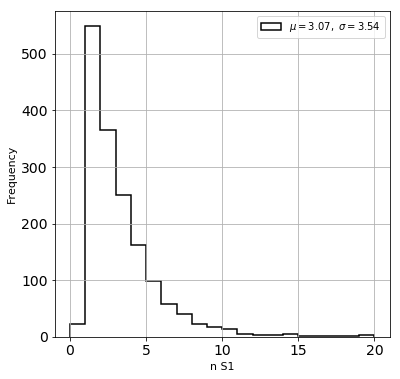

In [510]:
hns1, bins  = histo_ns1(ns1_5262)

In [511]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.014127764127764128 1S1/tot = 0.33722358722358725 2S1/tot = 0.22481572481572482


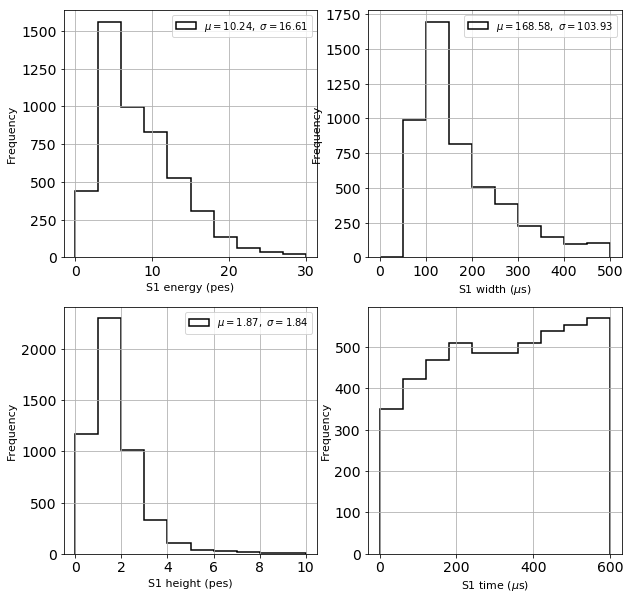

In [512]:
plot_s1histos(df5262, figsize=(10,10))

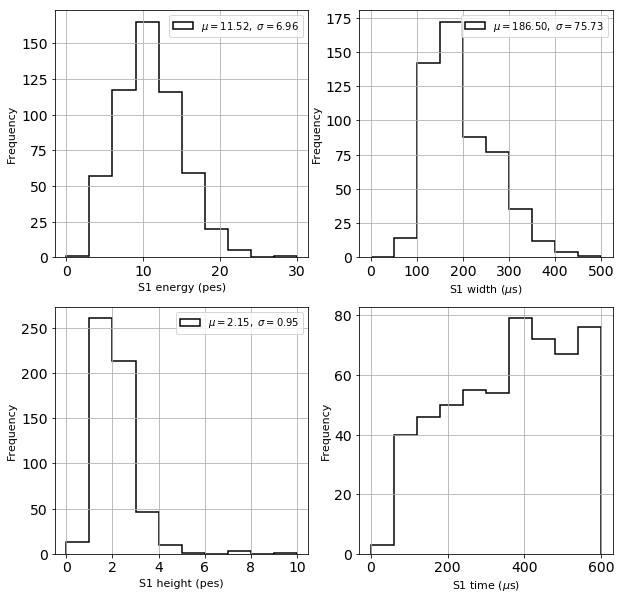

In [514]:
plot_s1histos(df5262[df5262.ns1==1], figsize=(10,10))

In [515]:
file_numbers = ['0{:d}'.format(i) for i in range(580,584)]
file_numbers

['0580', '0581', '0582', '0583']

In [516]:
filenames = file_list(run_number=5262, file_numbers=file_numbers)
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0580_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0581_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0582_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5262_0583_waveforms.h5']

In [517]:
ns1_5262_t1, ns2_5262_t1, df5262_t1 = s12df(run_number=5262, filenames=filenames, mode='S12', print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
processing event = 400
processing event = 500
processing event = 600
Time spent in s12df: 161.16131019592285 s


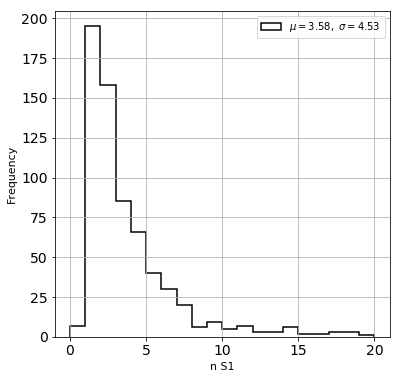

In [518]:
hns1, bins  = histo_ns1(ns1_5262_t1)

In [519]:
print(' 0S1/tot  = {} 1S1/tot = {} 2S1/tot = {}'.format(bin_ratio(hns1, bins, 0), 
                                                        bin_ratio(hns1, bins, 1),
                                                        bin_ratio(hns1, bins, 2)))

 0S1/tot  = 0.010752688172043012 1S1/tot = 0.2995391705069124 2S1/tot = 0.24270353302611367


In [520]:
filenames =['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_0001_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_0100_waveforms.h5']
filenames

['/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_0001_waveforms.h5',
 '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5261_0100_waveforms.h5']

In [521]:
ns1_5261, ns2_5261, df5261 = s12df(run_number=5261, filenames=filenames, mode='S12', print_every=100)

processing event = 0
processing event = 100
processing event = 200
processing event = 300
Time spent in s12df: 79.59309673309326 s


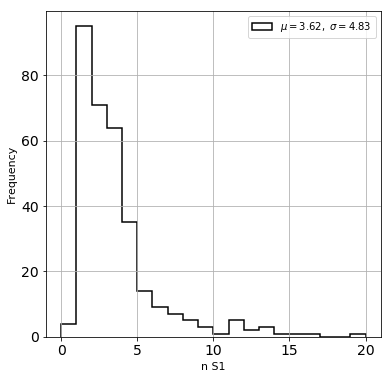

In [522]:
hns1, bins  = histo_ns1(ns1_5261)

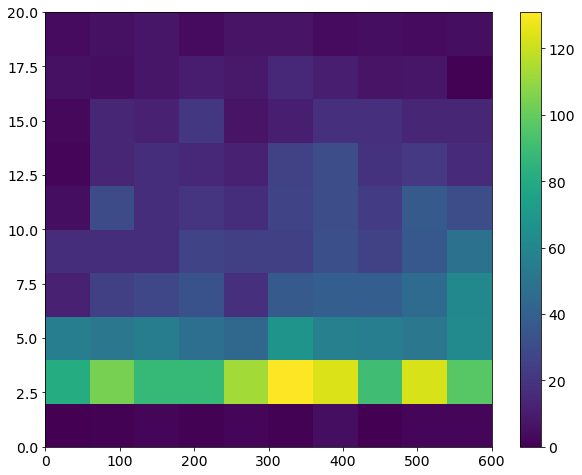

In [335]:
plt.hist2d(df5259.ts1, df5259.es1, bins=10, range=((0,600),(0,20)))
plt.colorbar()
plt.show()

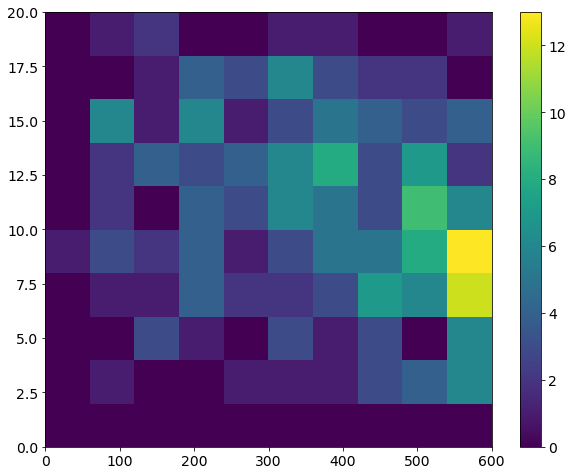

In [336]:
plt.hist2d(kr1.ts1, kr1.es1, bins=10, range=((0,600),(0,20)))
plt.colorbar()
plt.show()

In [152]:
df2 = s1df_5254[s1df_5254.ns1==1]

(array([ 9.,  7.,  6.,  3.,  4.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.37526368,   4.16053984,   6.94581601,   9.73109218,
         12.51636835,  15.30164452,  18.08692069,  20.87219686,
         23.65747303,  26.4427492 ,  29.22802537]),
 <a list of 10 Patch objects>)

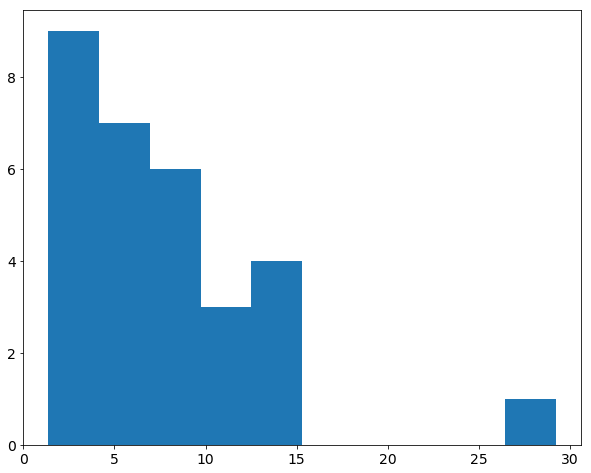

In [153]:
plt.hist(df2.es1)

In [130]:
a = s1h5254

In [132]:
a.cs1

array([2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 3, 3, 3, 1,
       1, 3, 3, 3, 4, 4, 4, 4, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 3, 3, 3, 2, 2, 5, 5, 5, 5, 5, 2, 2, 1, 1, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 3, 3, 3, 2,
       2, 3, 3, 3, 5, 5, 5, 5, 5, 1, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3])

In [131]:
data = np.array(a.cs1, a.es1, a.hs1, a.ws1, a.ts1)

ValueError: only 2 non-keyword arguments accepted

TypeError: only integer scalar arrays can be converted to a scalar index

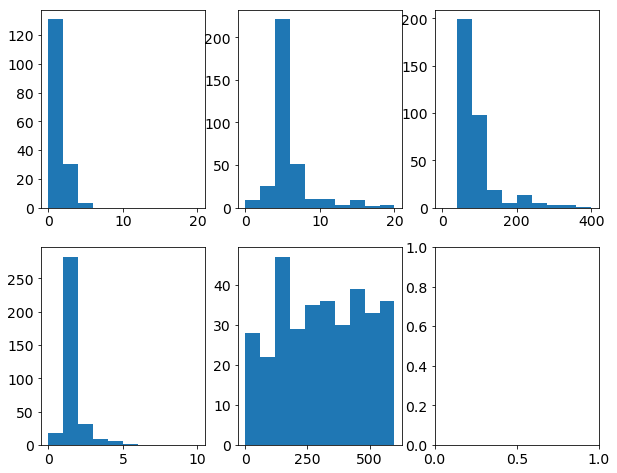

In [123]:
plot_s1histos(s1h5254)

In [84]:
pmtrwf = open_file('5253', '0001')
s1h5253 = eloop(pmtrwf, mau=False)

Time spent in eloop: 25.211530208587646 s


### G = 7 kV,  C = 30 kV

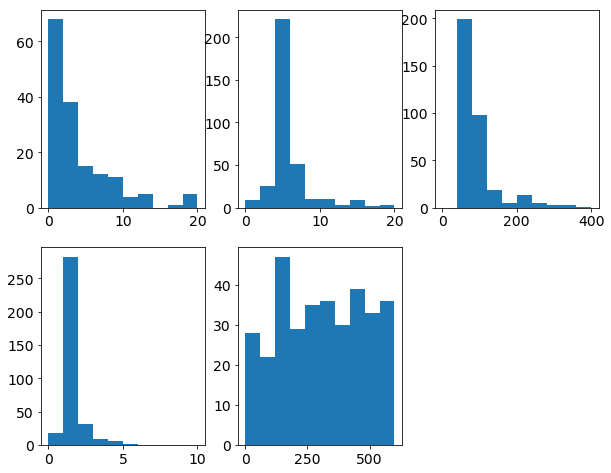

In [94]:
plot_s1histos(s1h5253)

In [95]:
pmtrwf = open_file('5252', '0001')
s1h5252 = eloop(pmtrwf, mau=False)

Time spent in eloop: 25.357315063476562 s


### G = 8 kV  C = 30 kV

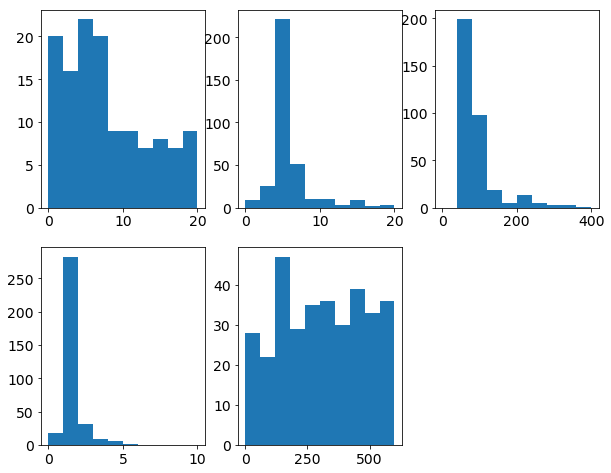

In [96]:
plot_s1histos(s1h5252)

In [97]:
pmtrwf = open_file('5251', '0001')
s1h5251 = eloop(pmtrwf, mau=False)

Time spent in eloop: 22.60313868522644 s


### C = 8 kV G = 8 kV

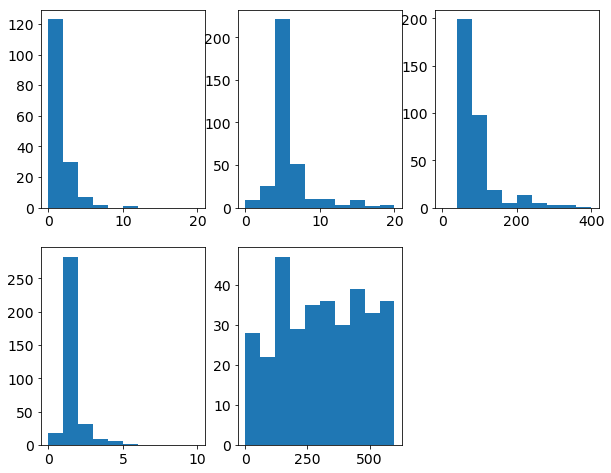

In [98]:
plot_s1histos(s1h5251)

In [118]:
s1h5254.es1.shape

(113,)

In [119]:
s1h5254.cs1.shape

(113,)

In [124]:
c = s1h5254.cs1[s1h5254.cs1==1]

In [125]:
c

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [126]:
c.shape

(30,)

In [128]:
s1h5253.cs1[s1h5253.cs1==1]

AttributeError: 'S1Histos' object has no attribute 'cs1'